In [12]:
from PIL import Image, ImageEnhance, ImageFilter
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import cv2
import torch
import glob
from torchvision import transforms
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf

from src.utils import show_image, preprocess_image, clip_eps, get_label
from src.utils_attack import compute_psnr, compute_ssim, compute_msssim, eval_psnr_ssim_msssim, bytearray_to_bits
from src.regen_pipe import ReSDPipeline
from src.blackbox import verify_watermark
from src.regen_attack import DiffWMAttacker

In [2]:
wm_text = 'test'
device = 'cuda:0'
print_width = 50

In [3]:
pipe = ReSDPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16, revision="fp16")
pipe.set_progress_bar_config(disable=True)
pipe.to(device)
print('Finished loading model')

/home/apurohit/.local/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /tmp/xdg-cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /tmp/xdg-cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /tmp/xdg-cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /tmp/xdg-cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Finished loading model


In [4]:
attackers = {
    'diff_attacker_60': DiffWMAttacker(pipe, batch_size=5, noise_step=60, captions={})
}

Diffuse attack initialized with noise step 60 and use prompt 0


In [5]:
attacker_name = "diff_attacker_60"
attacker = attackers[attacker_name]   # Select the attacker

print('*' * print_width)
print(f'Attacking PGD Blackbox Watermark with {attacker_name}')

# Define paths for the input and output of the attack
# watermarked_img_path = "blackbox_watermarked_image.jpg"  # Input image
watermarked_img_path = "examples/panda.jpg"
attacked_img_path = "original_panda_attacked.jpg"

# Move attacker model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attacker.pipe.to(device)  # Ensure the model is on the right device

# Apply the attack
attacker.attack([watermarked_img_path], [attacked_img_path])

print('Finished attacking')


**************************************************
Attacking PGD Blackbox Watermark with diff_attacker_60


1it [00:01,  1.03s/it]
/home/apurohit/.local/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:283: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/home/apurohit/.local/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


Finished attacking


In [9]:
resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=True, classifier_activation=None)


In [17]:
original_image_path = "examples/panda.jpg"
attacked_img_path = "attacked_blackbox_image.jpg"


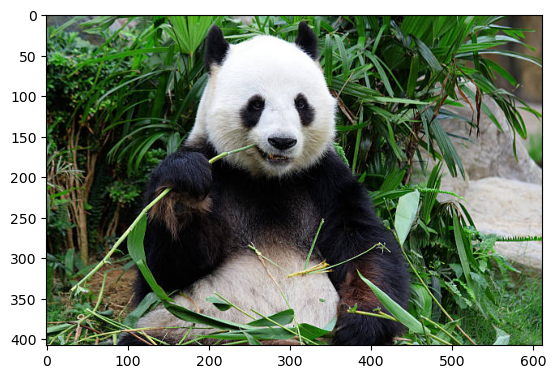

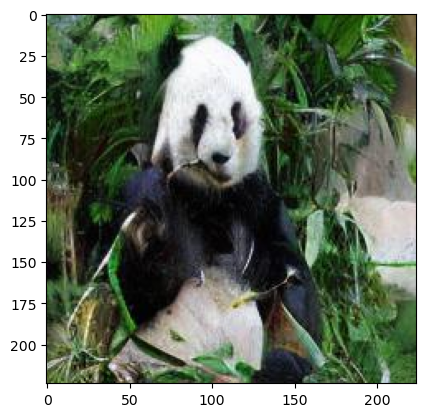

1/1 [==============================] - 0s 23ms/step


In [18]:
sample_image_org = show_image(original_image_path)
preprocessed_image_org = preprocess_image(sample_image_org)
image_tensor_org = tf.constant(preprocessed_image_org, dtype=tf.float32)

sample_image_att = show_image(attacked_img_path)
preprocessed_image = preprocess_image(sample_image_att)
image_tensor_att = tf.constant(preprocessed_image, dtype=tf.float32)

original_logits = resnet50.predict(preprocess_input(image_tensor_org))
attacked_logits = resnet50.predict(preprocess_input(image_tensor_att))

In [19]:
verify_watermark(original_logits, attacked_logits, [178,728,815,136])

Label: Weimaraner (178) | Logit Before: 2.69404 | Logit After: 4.15798 | Logit Diff: 1.46394
Label: plastic_bag (728) | Logit Before: 1.17153 | Logit After: 1.14218 | Logit Diff: -0.02935
Label: spider_web (815) | Logit Before: 0.69563 | Logit After: -0.36096 | Logit Diff: -1.05659
Label: European_gallinule (136) | Logit Before: 0.47942 | Logit After: 0.31362 | Logit Diff: -0.16580
0.05305185168981552


False